# STimage

In [53]:
%matplotlib inline

import os
import copy
import stlearn as st
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys; import scanpy as sc
from matplotlib import cm as cm
from typing import Optional, Union
from anndata import AnnData
from sklearn.cluster import AgglomerativeClustering
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
from numpy import array
from numpy import argmax
from numpy import load
import joblib
import cv2

import squidpy as sq
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from lime import lime_tabular

import lime; from lime import lime_image
import glob

import scipy as sp
from scipy import ndimage as ndi
from imblearn.over_sampling import SMOTE
#from tabgan.sampler import OriginalGenerator, GANGenerator

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from skimage.color import rgb2hed
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.segmentation import mark_boundaries, watershed
from skimage.morphology import area_opening


import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as image_fun

from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split; from sklearn.neural_network import MLPClassifier; from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")

Path = "D:/Onkar_D/UQ/Project_Spt_Transcriptomics/Output_files/"
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")

## Loading dataset and gene expression 

In [2]:
import pandas as pd
Path = "D:/Onkar_D/UQ/Project_Spt_Transcriptomics/Output_files/"
h5ad = pd.read_csv(Path+"h5ad_obs.csv", index_col=0)
h5ad['tile_tissue_mask_path'] = h5ad['tile_tissue_mask_path'].str.split('/', expand=True)[3].str[:-5]

gene_exp = pd.read_csv(Path+"gene_expression_visium.csv", index_col=0)

h5ad = h5ad.set_index(['tile_tissue_mask_path'])

resnet_features = pd.read_csv(Path+"Resnet50_features.csv", index_col=0).iloc[:,1:]
resnet_features.index = h5ad.index
resnet_features['dataset'] = resnet_features.index.to_series().str.split('-', expand=True)[0]
gene_exp.index = h5ad.index
gene_exp['dataset'] = list(resnet_features['dataset'])

set(resnet_features.index.to_series().str.split('-', expand=True)[0])

{'1142243F',
 '1160920F',
 'CID4290',
 'CID4465',
 'CID44971',
 'CID4535',
 'FFPE',
 'block1',
 'block2'}

## Train

In [3]:
gene_list = ['CD74', 'CD24', 'CD63', 'CD81', 'CD151', 'COX6C', 'TP53', 'PABPC1',
             'GNAS', 'B2M', 'SPARC', 'HSP90AB1', 'TFF3', 'ATP1A1', 'FASN']

train_data_library_id = "block1"

gene_exp_log = gene_exp.groupby('dataset')[gene_list].apply(lambda x: np.log((2*x)+1))
gene_exp_log['dataset'] = gene_exp['dataset']
gene_exp_zscore = gene_exp_log.groupby('dataset')[gene_list].apply(lambda x: (x-x.mean())/(x.std()))
gene_exp_binary = gene_exp_zscore.apply(lambda x: [0 if y <= 0 else 1 for y in x])
gene_exp_binary['dataset'] = gene_exp['dataset']

model_c = MLPClassifier(max_iter=10000, hidden_layer_sizes=(150,100,50), early_stopping=True, random_state=0, activation = 'relu')


#clf_resnet = MultiOutputClassifier(model_c).fit(resnet_features.loc[(resnet_features['dataset'] == train_data_library_id)].iloc[:,:-1], gene_exp_binary.loc[(gene_exp_binary['dataset'] == train_data_library_id)].iloc[:,:-1])
#joblib.dump(clf_resnet, Path+'pickle/resnet_block1_log_scaled_relu_2.pkl')
clf_resnet = joblib.load(Path+'pickle/resnet_block1_log_scaled_relu_2.pkl')
pred_gexp = pd.DataFrame(clf_resnet.predict(resnet_features.loc[(resnet_features['dataset'] != train_data_library_id)].iloc[:,:-1]),columns=gene_exp.iloc[:,:-1].columns,index=resnet_features.loc[(resnet_features['dataset'] != train_data_library_id)].index)
pred_gexp['dataset'] = resnet_features.loc[(resnet_features['dataset'] != train_data_library_id)]['dataset']

performance_metrics_all_predictions = [x for _, x in pred_gexp.groupby('dataset')]
gene_exp_binary_all_true = [x for _, x in gene_exp_binary.loc[(gene_exp_binary['dataset'] != train_data_library_id)].groupby('dataset')]



AUROC_genes = []; F1_genes = []; Precision_genes = []; Recall_genes = []
for dataset in range(len(gene_exp_binary_all_true)):
    for gene in range(len(pred_gexp.iloc[:,:-1].T)):
        score =  roc_auc_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                               gene_exp_binary_all_true[dataset].iloc[:,gene])
        AUROC_genes.append(score)
        
for dataset in range(len(gene_exp_binary_all_true)):
    for gene in range(len(pred_gexp.iloc[:,:-1].T)):
        score =  f1_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                               gene_exp_binary_all_true[dataset].iloc[:,gene])
        F1_genes.append(score)
        
for dataset in range(len(gene_exp_binary_all_true)):
    for gene in range(len(pred_gexp.iloc[:,:-1].T)):
        score =  precision_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                               gene_exp_binary_all_true[dataset].iloc[:,gene])
        Precision_genes.append(score)
        
for dataset in range(len(gene_exp_binary_all_true)):
    for gene in range(len(pred_gexp.iloc[:,:-1].T)):
        score =  recall_score(performance_metrics_all_predictions[dataset].iloc[:,gene],
                               gene_exp_binary_all_true[dataset].iloc[:,gene])
        Recall_genes.append(score)
        
AUROC_genes = pd.DataFrame(AUROC_genes); F1_genes = pd.DataFrame(F1_genes); Precision_genes = pd.DataFrame(Precision_genes); Recall_genes = pd.DataFrame(Recall_genes)
Performance_metrics = pd.concat([AUROC_genes,F1_genes,Precision_genes,Recall_genes])
Performance_metrics['genes'] = list(gene_exp.iloc[:,:-1].columns)*8*4
Performance_metrics['patient'] = list(np.repeat(pd.concat(gene_exp_binary_all_true).loc[(pd.concat(gene_exp_binary_all_true)['dataset'] != train_data_library_id)].drop_duplicates('dataset', keep='first')['dataset'].to_list(),15))*4
Performance_metrics['measure'] = ['AUROC']*len(AUROC_genes)+['F1']*len(F1_genes)+['Precision']*len(Precision_genes)+['Recall']*len(Recall_genes)
Performance_metrics

,0,genes,patient,measure
0,0.572367,CD74,1142243F,AUROC
1,0.480338,CD24,1142243F,AUROC
2,0.501738,CD63,1142243F,AUROC
3,0.511588,CD81,1142243F,AUROC
4,0.496616,CD151,1142243F,AUROC
...,...,...,...,...
115,0.592952,SPARC,block2,Recall
116,0.733584,HSP90AB1,block2,Recall
117,0.676335,TFF3,block2,Recall
118,0.605796,ATP1A1,block2,Recall


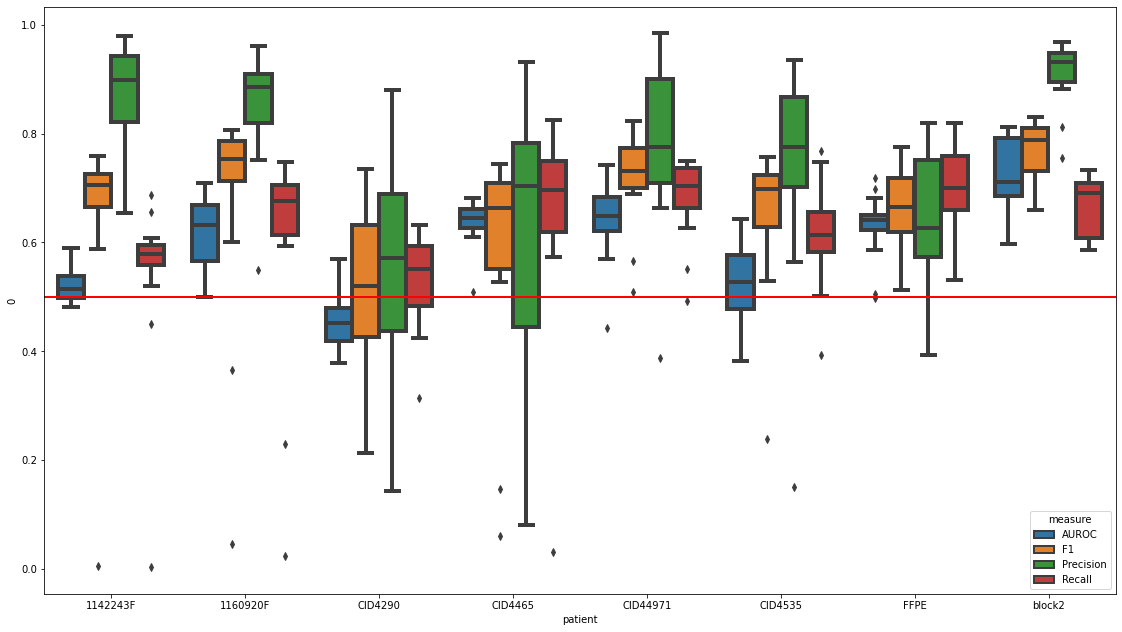

In [4]:
plt.figure(figsize=(19.20,10.80))
im = sns.boxplot(x="patient", y=0, hue="measure", data=Performance_metrics,linewidth=4)
im.axhline(0.5, linewidth=2, color='r')
#im.figure.savefig(Path+'Classification_boxplot.png')

## Gene Plotting on Tissue

In [11]:
def gene_plot(Path_of_the_tissue, gene, patient):
    image = cv2.imread(Path_of_the_tissue)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    patients_list = pd.concat(gene_exp_binary_all_true).loc[(pd.concat(gene_exp_binary_all_true)['dataset'] != train_data_library_id)].drop_duplicates('dataset', keep='first')['dataset'].to_list()
    Spots_Cluster_patient = pd.DataFrame(performance_metrics_all_predictions[patients_list.index(patient)][gene])
    Spots_Cluster = pd.concat([h5ad.loc[((h5ad['library_id'] == patient))][["imagerow","imagecol"]], Spots_Cluster_patient], axis=1)


    Spot_vals0=Spots_Cluster[Spots_Cluster[gene] == 0]
    Spot_vals0=Spot_vals0.values
    Spot_vals1=Spots_Cluster[Spots_Cluster[gene] == 1]
    Spot_vals1=Spot_vals1.values


    x = Spot_vals0[:,0].astype('int64')
    y = Spot_vals0[:,1].astype('int64')
    box = (y,x)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()

    x1 = Spot_vals1[:,0].astype('int64')
    y1 = Spot_vals1[:,1].astype('int64')
    box1 = (y1,x1)
    numpy_array1 = np.array(box1)
    transpose1 = numpy_array1.T
    box1 = transpose1.tolist()


    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 60,(139,0,0), -1)
    for i in range(0,len(box1)):
        image=cv2.circle(image, tuple(box1[i]), 60,(0,255,0), -1)
    return cv2.imwrite(Path+"Other/"+gene+"_pred_ffpe_gMLP.png",image)
    
    
Path_of_the_tissue = Path+"Other/FFPE/Visium_FFPE_Human_Breast_Cancer_image.tif" #V1_Breast_Cancer_Block_A_Section_2_image
gene = "COX6C"
patient = "FFPE"
gene_plot(Path_of_the_tissue, gene, patient)

True

## Clustering

In [33]:
clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
clf_can_v_non_can = model_c.fit(gene_exp_binary.loc[(gene_exp_binary['dataset'] == train_data_library_id)].iloc[:,:-1],
                                                      clustering.fit_predict(gene_exp_binary.loc[(gene_exp_binary['dataset'] == train_data_library_id)].iloc[:,:-1]))
can_v_non_can_spot = pd.DataFrame(clf_can_v_non_can.predict(pred_gexp.iloc[:,:-1]))
can_v_non_can_spot['dataset'] = list(pred_gexp['dataset'])
can_v_non_can_spot.head(5)

,0,dataset
0,1,1142243F
1,1,1142243F
2,1,1142243F
3,1,1142243F
4,1,1142243F


(22116.0, 4048.0)

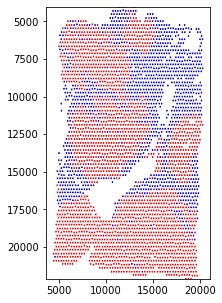

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
x = h5ad.loc[((h5ad['library_id'] == "block1"))]["imagerow"] 
y = h5ad.loc[((h5ad['library_id'] == "block1"))]["imagecol"] 
c = pd.DataFrame(clustering.fit_predict(gene_exp_binary.loc[(gene_exp_binary['dataset'] == train_data_library_id)].iloc[:,:-1]))         
fig1 = plt.gcf()
plt.hexbin(y,x, C=c, cmap=cm.bwr, gridsize=300)
plt.ylim(max(x), min(x)) 

(21325.0, 3720.0)

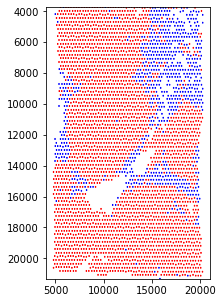

In [47]:
patient = "block2"
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
x = h5ad.loc[((h5ad['library_id'] == patient))]["imagerow"] 
y = h5ad.loc[((h5ad['library_id'] == patient))]["imagecol"] 
c = can_v_non_can_spot.loc[(can_v_non_can_spot['dataset']==patient)].iloc[:,:-1]        
fig1 = plt.gcf()
plt.hexbin(y,x, C=c, cmap=cm.bwr, gridsize=300)
plt.ylim(max(x), min(x)) 

(21057.0, 5407.0)

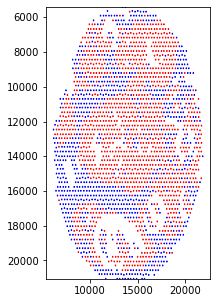

In [48]:
patient = "FFPE"
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
x = h5ad.loc[((h5ad['library_id'] == patient))]["imagerow"] 
y = h5ad.loc[((h5ad['library_id'] == patient))]["imagecol"] 
c = can_v_non_can_spot.loc[(can_v_non_can_spot['dataset']==patient)].iloc[:,:-1]        
fig1 = plt.gcf()
plt.hexbin(y,x, C=c, cmap=cm.bwr, gridsize=300)
plt.ylim(max(x), min(x)) 

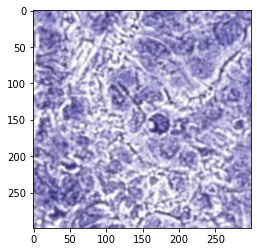

In [76]:
Image_file = 'D:\\Onkar_D\\UQ\\Project_Spt_Transcriptomics\\Output_files\\Good_Norm_Tiles\\block2\\block2-8509-12754-299.jpeg'
image = np.asarray(image_fun.load_img(Image_file)).reshape(1,299,299,3)
explainer_tabular = lime_tabular.LimeTabularExplainer(np.array(gene_exp_binary.loc[(gene_exp_binary['dataset'] == train_data_library_id)].iloc[:,:-1]), 
                                                      feature_names=gene_exp.columns, class_names=['0','1'], mode='classification')
plt.imshow(Image.open(Image_file))

In [77]:
exp = explainer_tabular.explain_instance(data_row=clf_resnet.predict(resnet_model(image))[0], predict_fn=clf_can_v_non_can.predict_proba)
exp.show_in_notebook(show_table=True)

## SHAP

In [ ]:
"""import os
import numpy as np
import pandas as pd
from PIL import Image
import warnings, json, re, glob, math, shutil, os, shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from sklearn.model_selection import KFold
from classification_models.tfkeras import Classifiers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)

def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    ResNet50, preprocess_input = Classifiers.get('resnet50')
    base_model = ResNet50(input_shape=input_shape, 
                          weights="imagenet", 
                          include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_image, outputs=output)
    return model

images = glob.glob('D:/Onkar_D/UQ/Project_Spt.Transcriptomics/Output_files/LIME/*.jpeg')
x_train = np.array([np.array(Image.open(fname)) for fname in images])


model = model_fn((299, 299, 3))
masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)
explainer = shap.Explainer(f, masker, output_names=['High'])
shap_values = explainer(x_train, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.imshow(((shap_values[0].values*10e6).reshape(299,299,3)*255).astype(np.uint8),cmap='bwr')
plt.subplot(1,5,2)
plt.imshow(((shap_values[1].values*10e6).reshape(299,299,3)*255).astype(np.uint8),cmap='bwr')
plt.subplot(1,5,3)
plt.imshow(((shap_values[2].values*10e6).reshape(299,299,3)*255).astype(np.uint8),cmap='bwr')
plt.subplot(1,5,4)
plt.imshow(((shap_values[3].values*10e6).reshape(299,299,3)*255).astype(np.uint8),cmap='bwr')
plt.subplot(1,5,5)
plt.imshow(((shap_values[4].values*10e6).reshape(299,299,3)*255).astype(np.uint8),cmap='bwr')"""

## LIME

In [83]:
gene_list_2 = gene_exp.columns[:-1].to_list()

def model_predict_gene(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model.predict(tile1)
        prediction = clf_resnet.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=0.01)
    thresh = skimage.filters.threshold_otsu(annotation_h)*0.7
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def cell_summary(file_path,cell_type_input):
    cell_summary_tile = pd.read_csv(file_path)
    return cell_summary_tile.loc[(cell_summary_tile['cell_type'] == cell_type_input)]

def IOU(Ref_mask,Lime_mask):
    Lime_mask[Lime_mask == -1] = 0
    coordinate_x = np.array(round(Ref_mask['coordinate_x'])).astype('int64')
    coordinate_y = np.array(round(Ref_mask['coordinate_y'])).astype('int64')
    mask_initialised = np.array([[0]*299]*299)
    mask_initialised[coordinate_x,coordinate_y] = 1
    
    overlap = mask_initialised*Lime_mask # Logical AND
    return overlap.sum()/float(mask_initialised.sum())

def LIME_p_value(heatmap_cancer, heatmap_immune, cell_summary_Tumor, cell_summary_lymphocyte_stroma, cancer_mask, immune_mask):
    tumor_lime_score = []; immune_lime_score = []; tumor = []; immune = []

    for i in range(0,len(cell_summary_Tumor)):
        if cancer_mask[np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')][np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')]>0:
            tumor_lime_score.append(heatmap_cancer[np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')][np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')])
    for i in range(0,len(cell_summary_lymphocyte_stroma)):
        if immune_mask[np.round(cell_summary_lymphocyte_stroma['coordinate_x'][i]).astype('int64')][np.round(cell_summary_lymphocyte_stroma['coordinate_y'][i]).astype('int64')]>0:
            immune_lime_score.append(heatmap_immune[np.round(cell_summary_lymphocyte_stroma['coordinate_x'][i]).astype('int64')][np.round(cell_summary_lymphocyte_stroma['coordinate_y'][i]).astype('int64')])


    cell_summary_Tumor = np.ones((len(tumor_lime_score),), dtype=int)
    tumor = np.where(np.asarray(tumor_lime_score)==0, 0,1)

    cell_summary_lymphocyte_stroma = np.ones((len(immune_lime_score),), dtype=int)
    immune = np.where(np.asarray(immune_lime_score)==0, 0,1)

    cell_summary_Tumor_val = [np.sum(cell_summary_Tumor==0),np.sum(cell_summary_Tumor==1)]
    cell_summary_lymphocyte_stroma_val = [np.sum(cell_summary_lymphocyte_stroma==0),np.sum(cell_summary_lymphocyte_stroma==1)]

    tumor_val = [np.sum([tumor==0]),np.sum([tumor==1])]
    immune_val = [np.sum([immune==0]),np.sum([immune==1])]

    table_tumor = [[tumor_val[1],0],[np.sum([cell_summary_Tumor==1])-tumor_val[1],0]]
    p_value_tumor = mcnemar(table_tumor, exact=True)

    table_immune = [[immune_val[1],0],[np.sum([cell_summary_lymphocyte_stroma==1])-immune_val[1],0]]
    p_value_immune = mcnemar(table_immune, exact=True)

    oddsr_tumor, p_fisher_tumor = fisher_exact(table_tumor, alternative='two-sided')
    oddsr_immune, p_fisher_immune = fisher_exact(table_immune, alternative='two-sided')


    accuracy = ["Accuracy of Tumor Nuclei is:",accuracy_score(np.asarray(cell_summary_Tumor),np.asarray(tumor)),"Accuracy of Immune Nuclei is:",accuracy_score(np.asarray(cell_summary_lymphocyte_stroma),np.asarray(immune)),
              "Average Accuracy of LIME Model is:",(accuracy_score(np.asarray(cell_summary_Tumor),np.asarray(tumor))+accuracy_score(np.asarray(cell_summary_lymphocyte_stroma),np.asarray(immune)))/2]

    return accuracy#, p_value_tumor, p_value_immune, p_fisher_tumor, p_fisher_immune


explainer = lime_image.LimeImageExplainer()

In [84]:
image1 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-7318-11963-299.jpeg'))
immune_genes = ['CD74','CD24','CD63','CD81','CD151']
cancer_genes = ['COX6C','TP53','PABPC1','GNAS','B2M']

explanation1 = explainer.explain_instance(image1, model_predict_gene(immune_genes[0]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation2 = explainer.explain_instance(image1, model_predict_gene(immune_genes[1]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation3 = explainer.explain_instance(image1, model_predict_gene(immune_genes[2]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation4 = explainer.explain_instance(image1, model_predict_gene(immune_genes[3]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation5 = explainer.explain_instance(image1, model_predict_gene(immune_genes[4]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)

explanation6 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[0]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation7 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[1]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation8 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[2]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation9 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[3]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)
explanation10 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[4]), top_labels=2, hide_color=0, num_samples=100, segmentation_fn=watershed_segment)

temp1, mask1 = explanation1.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp2, mask2 = explanation2.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp3, mask3 = explanation3.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp4, mask4 = explanation4.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp5, mask5 = explanation5.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp6, mask6 = explanation6.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp7, mask7 = explanation7.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp8, mask8 = explanation8.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp9, mask9 = explanation9.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp10, mask10 = explanation10.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

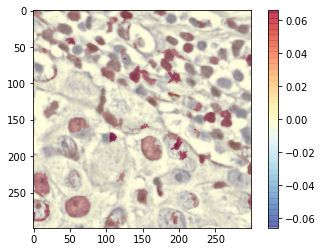

In [85]:
immune_mask_1 = (mask1+mask2+mask3+mask4+mask5)/5
cancer_mask_1 = (mask6+mask7+mask8+mask9+mask10)/5

dict_heatmap1 = dict(explanation1.local_exp[1])
heatmap1 = np.vectorize(dict_heatmap1.get)(explanation1.segments)

dict_heatmap2 = dict(explanation2.local_exp[1])
heatmap2 = np.vectorize(dict_heatmap2.get)(explanation2.segments)

dict_heatmap3 = dict(explanation3.local_exp[1])
heatmap3 = np.vectorize(dict_heatmap3.get)(explanation3.segments)

dict_heatmap4 = dict(explanation4.local_exp[1])
heatmap4 = np.vectorize(dict_heatmap4.get)(explanation4.segments)

dict_heatmap5 = dict(explanation5.local_exp[1])
heatmap5 = np.vectorize(dict_heatmap5.get)(explanation5.segments)

heatmap_immune_1 = heatmap1+heatmap2+heatmap3+heatmap4+heatmap5
heatmap_immune_1[heatmap_immune_1<0]=0
plt.imshow(image1,alpha=1)
plt.imshow(heatmap_immune_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_immune_1.max(), vmin=-heatmap_immune_1.max())
plt.colorbar()

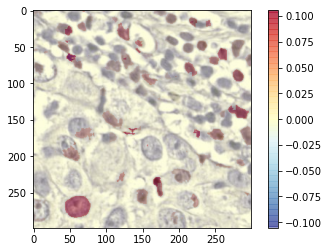

In [86]:
dict_heatmap6 = dict(explanation6.local_exp[1])
heatmap6 = np.vectorize(dict_heatmap6.get)(explanation6.segments)

dict_heatmap7 = dict(explanation7.local_exp[1])
heatmap7 = np.vectorize(dict_heatmap7.get)(explanation7.segments)

dict_heatmap8 = dict(explanation8.local_exp[1])
heatmap8 = np.vectorize(dict_heatmap8.get)(explanation8.segments)

dict_heatmap9 = dict(explanation9.local_exp[1])
heatmap9 = np.vectorize(dict_heatmap9.get)(explanation9.segments)

dict_heatmap10 = dict(explanation10.local_exp[1])
heatmap10 = np.vectorize(dict_heatmap10.get)(explanation10.segments)

heatmap_cancer_1 = heatmap6+heatmap7+heatmap8+heatmap9+heatmap10
heatmap_cancer_1[heatmap_cancer_1<0]=0
plt.imshow(image1)
plt.imshow(heatmap_cancer_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_cancer_1.max(), vmin=-heatmap_cancer_1.max())
plt.colorbar()